In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from tqdm.notebook import tqdm
import urllib.request


In [53]:


def parse_dimacs_to_adjacency_matrix(url):
    # Open the URL and read the lines
    with urllib.request.urlopen(url) as u:
        content = u.read().decode()

    # Split the content into lines
    lines = content.split("\n")
    
    # Filter only the lines that start with 'p' and 'e'
    p_lines = [line for line in lines if line.startswith('p')]
    e_lines = [line for line in lines if line.startswith('e')]

    # Parse the 'p' line to get the number of vertices
    _, _, num_vertices, _ = p_lines[0].split()
    num_vertices = int(num_vertices)

    # Initialize an empty adjacency matrix
    adjacency_matrix = np.zeros((num_vertices, num_vertices))

    # Parse each 'e' line and fill in the adjacency matrix
    for line in e_lines:
        _, vertex1, vertex2 = line.split()
        vertex1, vertex2 = int(vertex1) - 1, int(vertex2) - 1  # vertices are 1-indexed in the DIMACS format
        adjacency_matrix[vertex1][vertex2] = 1
        adjacency_matrix[vertex2][vertex1] = 1  # this is because the graph is undirected

    return adjacency_matrix

graph_url = 'http://cedric.cnam.fr/~porumbed/graphs/dsjc125.1.col'
graph_url = 'http://cedric.cnam.fr/~porumbed/graphs/dsjc500.5.col'
adjacency_matrix = parse_dimacs_to_adjacency_matrix(graph_url)

print(adjacency_matrix)


[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 1.]
 [1. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [54]:
cache_file = 'cache.csv'

def convert_to_primitives(data):
    
    if isinstance(data, np.ndarray):
        return data.tolist()
    if isinstance(data, dict):
        temp = {}
        for k, v in data.items():
            converted_k = convert_to_primitives(k)
            converted_v = convert_to_primitives(v)
            temp[converted_k] = converted_v
        return temp
    if isinstance(data, list):
        temp = []
        for item in data:
            converted_item = convert_to_primitives(item)
            temp.append(converted_item)
        return temp
    return data
    
def serialize_data(data):
    # check if np array
    temp = convert_to_primitives(data)
    
    return json.dumps(temp)

def load_cache(cache_df, file, run_parameters):
    alpha_value = run_parameters['alpha']
    tmin = run_parameters['tmin']
    tmax = run_parameters['tmax']
    generations = run_parameters['generations']
    population_size = run_parameters['population_size']
    generations = run_parameters['generations']

    cache_df["alpha"] = np.round(cache_df["alpha"], 2)

    # Filter DataFrame based on conditions
    cache_result = cache_df.query(
        f'file == "{file}" and '
        f'population_size == {population_size} and '
        f'generations == {generations} and '
        f'alpha == {round(alpha_value, 2)} and '
        f'tmax == {tmax} and '
        f'generations == {generations} and '
        f'tmin == {tmin}'
    )
    
    # Check if there's a match
    if not cache_result.empty:
        # Extract the first match
        result = cache_result.iloc[0]
        clique_mean = json.loads(result['clique_mean'])
        best_clique = json.loads(result['best_clique'])
        stds = np.array(json.loads(result['stds']))
        print("Loaded from cache")
        #display(cache_result)
   
        return clique_mean, best_clique, stds
    else:
        return None


def save_cache(cache_df, data, final_fitness, file, run_parameters):
    alpha_value = run_parameters['alpha']
    tmin = run_parameters['tmin']
    tmax = run_parameters['tmax']
    generations = run_parameters['generations']
    population_size = run_parameters['population_size']
    
    clique_mean, best_clique, _, stds = data
    std_last_gen = serialize_data(stds[-1])
    # Convert lists of lists into JSON
    mean_stats_json = serialize_data(clique_mean)
    best_clique_json = serialize_data(best_clique)
    stds_json = serialize_data(stds)

    final_std = stds[-1][0]

    new_row = {
        "file": file,
        "population_size": population_size,
        "final_fitness": final_fitness,
        "final_std" : final_std,
        "alpha": alpha_value,
        "tmin": tmin,
        "tmax": tmax,
        "generations": generations,
        "clique_mean": mean_stats_json,
        "best_clique": best_clique_json,
        "stds": stds_json,
        "std_last_gen": std_last_gen,
    }
   
    cache_df = pd.concat([cache_df, pd.DataFrame([new_row])], ignore_index=True)
    cache_df.to_csv(cache_file, index=False)
    return cache_df

In [55]:

def draw_graph(G, clique=None, title=None):
    # Let's use a circular layout for the vertices
    t = np.linspace(0, 2*np.pi, num=G.shape[0]+1)[:-1]
    x = np.cos(t)
    y = np.sin(t)

    fig, ax = plt.subplots()

    # make the figsize proportional to the number of vertices
    fig.set_size_inches(6*(G.shape[0]/50), 6*(G.shape[0]/50))
    
    # draw vertices
    ax.scatter(x, y)

    # draw edges
    for i in range(G.shape[0]):
        for j in range(i+1, G.shape[0]):
            if G[i, j] == 1:
                ax.plot([x[i], x[j]], [y[i], y[j]], color='gray')

    # highlight clique
    if clique is not None:
        if not isinstance(clique, list):
            clique = list(clique)
        cx = x[clique]
        cy = y[clique]
        ax.scatter(cx, cy, color='red')
        for i in range(len(clique)):
            for j in range(i+1, len(clique)):
                ax.plot([cx[i], cx[j]], [cy[i], cy[j]], color='red')
    
    if title is not None:
        ax.set_title(title)

    plt.show()
    


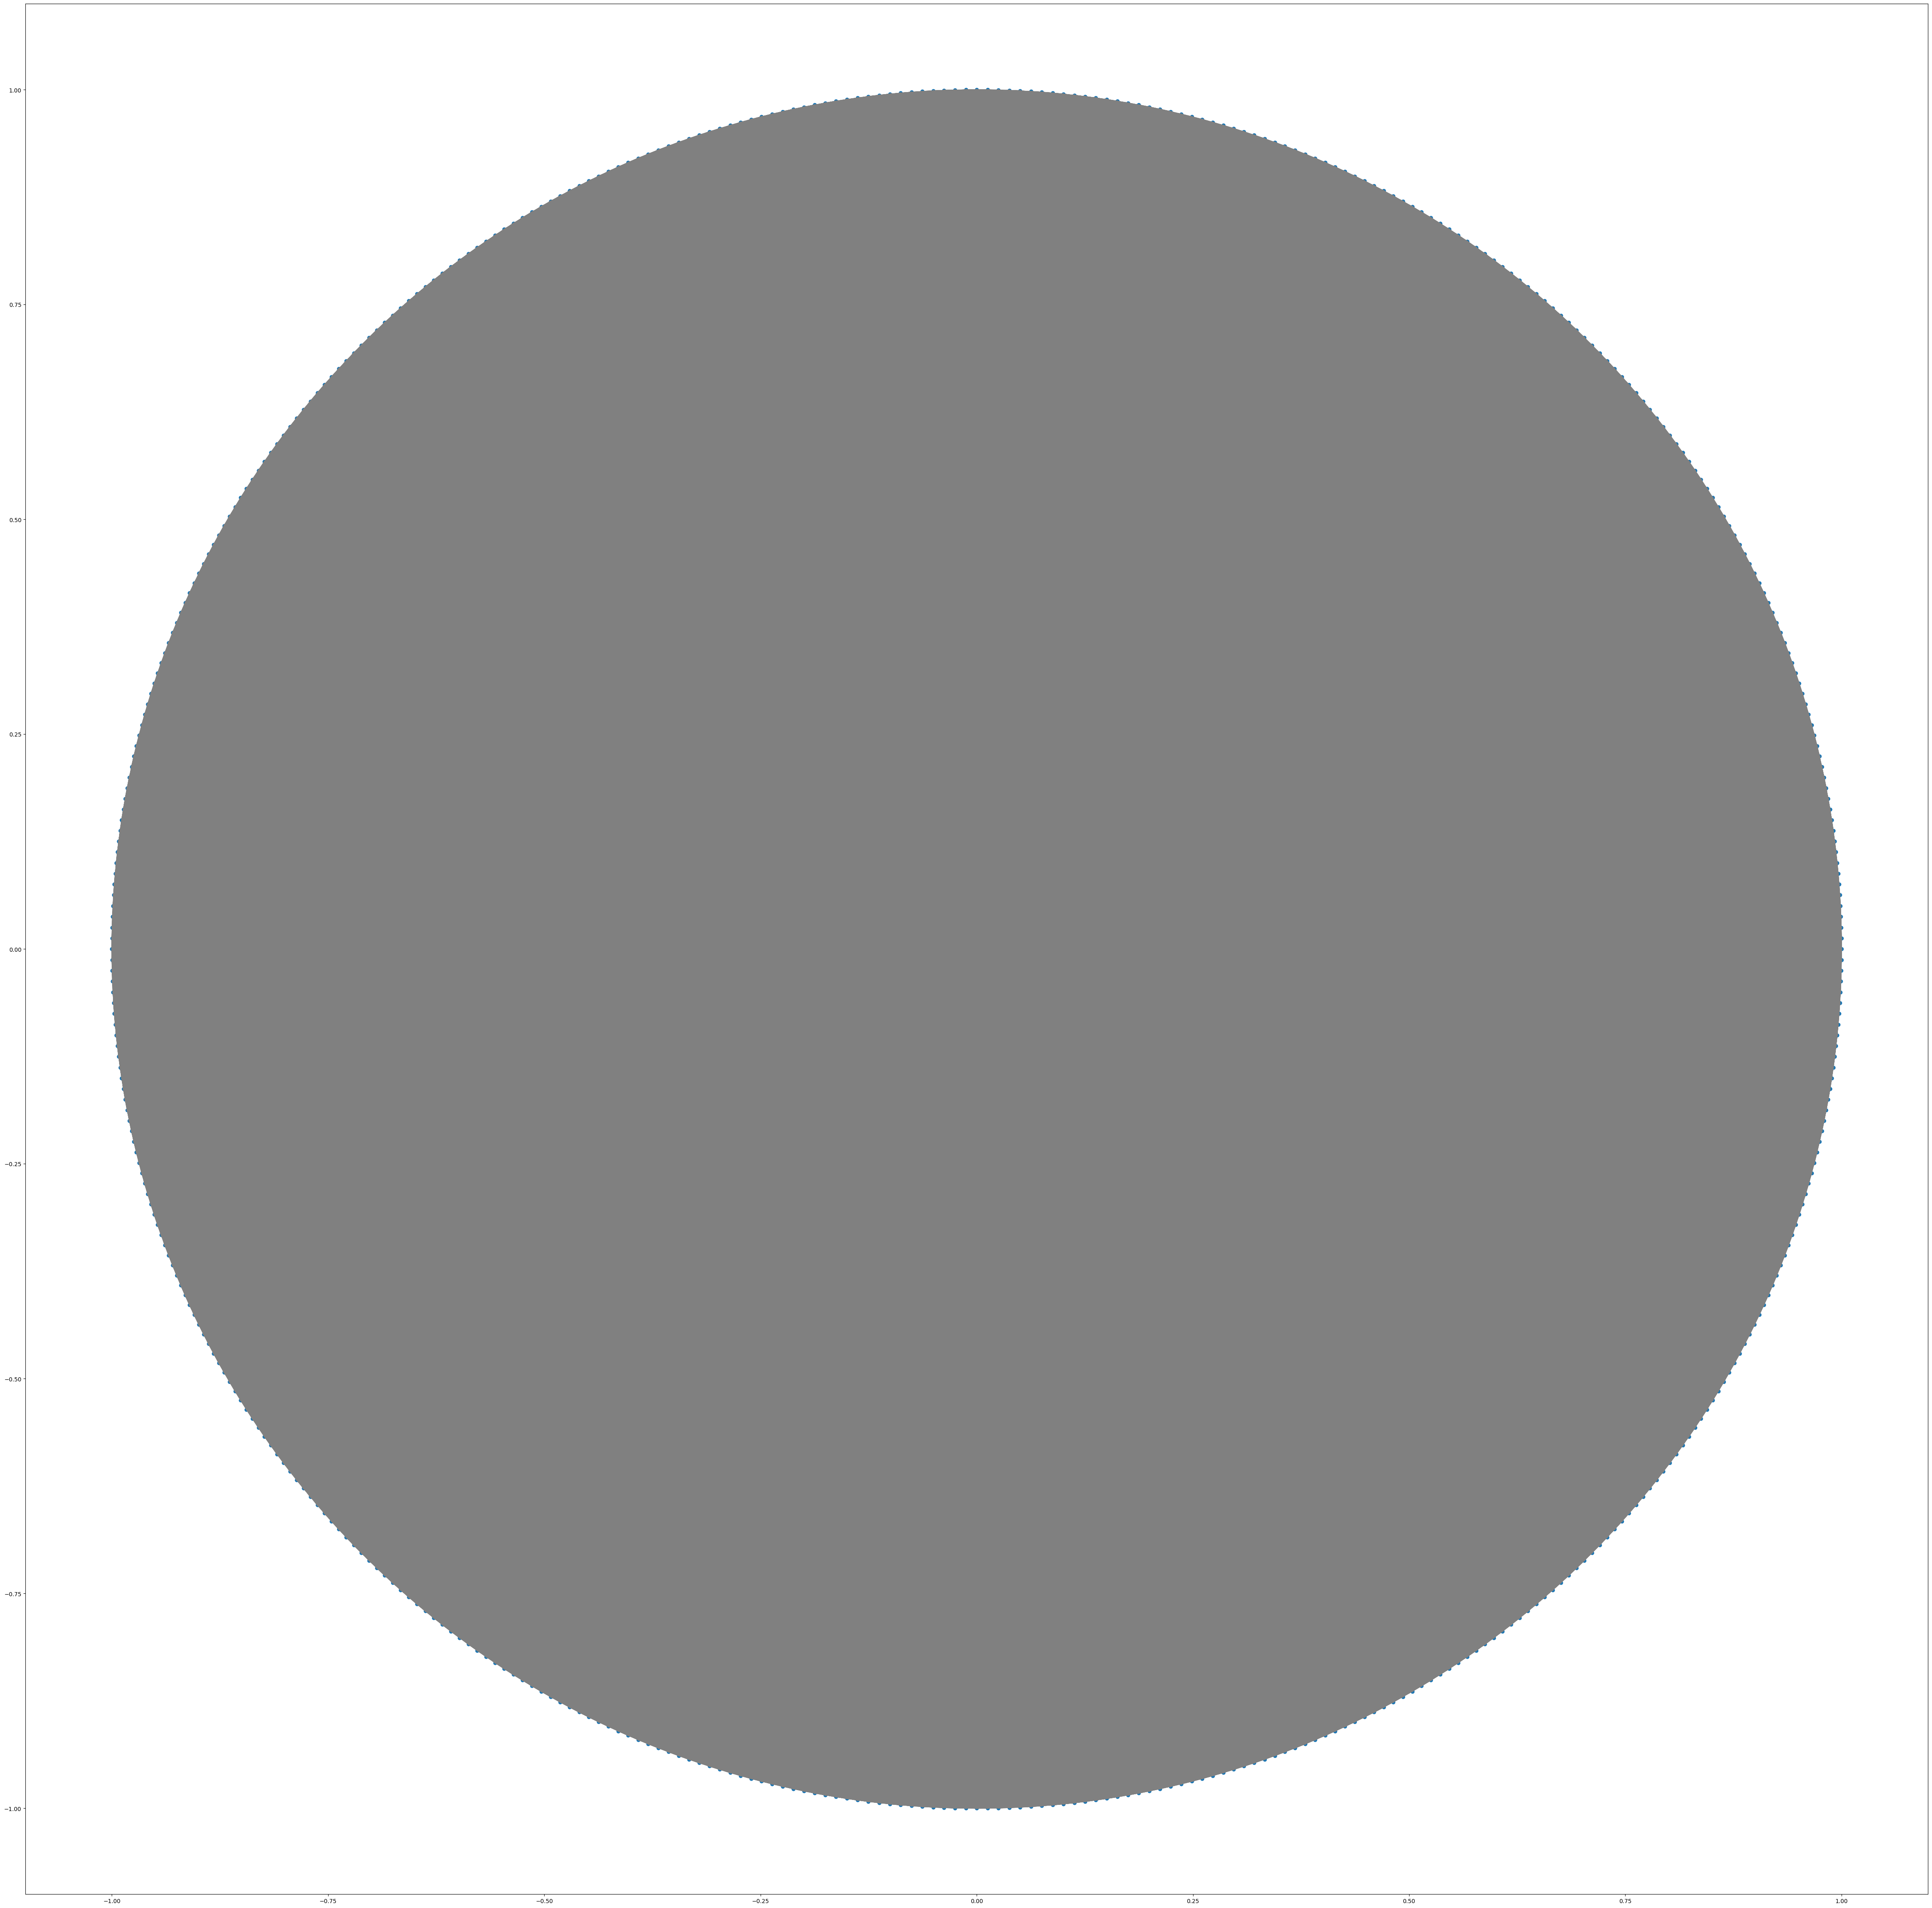

In [56]:
# create a 20x20 matrix filled with zeros
G = np.zeros((20, 20), dtype=int)
np.random.seed(42)
# create a 4-clique (vertices 0 to 3 form the clique)
G[0:4, 0:4] = 1

# add edges (0, 4), (1, 5), (3, 5) and (2, 4)
random_additions = 20

for i in range(random_additions):
    x = np.random.randint(0, 20)
    y = np.random.randint(0, 20)
    if x == y:
        y = np.random.randint(0, 20)
    G[x, y] = G[y, x] = 1


# connect edges that are disconnected

for i in range(len(G)):
    if np.sum(G[i]) == 0:
        G[i, i+1] = G[i+1, i] = 1

# Verify the graph
G = adjacency_matrix
#print(G)
#draw_graph(G)



In [61]:
def ant_clique(G, nbAnts, maxCycles, tauMin, tauMax, alpha=1.05, evaporation_rate=0.9, plot=False):
    tau = np.full_like(G, tauMax)  # initialize pheromone trails
    n = len(G)  # number of vertices in the graph

    def construct_clique():
        vi = np.random.randint(n)  # choose a first vertex
        Ck = {vi}  # initialize clique
        Candidates = {vj for vj in range(n) if G[vi, vj]}  # find neighbors

        while Candidates:  # continue while there are candidates
            # TODO: add alpha factor to exponent
            probs = [tau[vi, vj] for vj in Candidates]  # get pheromone trails
            probs   = np.power(probs, alpha)  # raise to alpha factor
            probs /= np.sum(probs)  # normalize to get probabilities
            vi = np.random.choice(list(Candidates), p=probs)  # choose next vertex

            new_neighbors = {vj for vj in range(n) if G[vi, vj]}  # find new neighbors
            Candidates &= new_neighbors  # update candidates to be the intersection of current candidates and new neighbors

            if all(G[vi][v] for v in Ck):  # if the new vertex is a neighbor of all vertices in the current clique
                Ck.add(vi)  # then add it to the clique

        return Ck

    bestClique = set()

    for cycle in tqdm(range(maxCycles), desc='Main loop'):
        cliques = [construct_clique() for _ in range(nbAnts)]  # construct cliques
        iteration_best_clique = max(cliques, key=len)
        
        title = f"Cicle {cycle+1}/{maxCycles} - Largest clique: {len(iteration_best_clique)} vertices"
        if plot:
            draw_graph(G, iteration_best_clique, title)
        else:
            print(title)
        # update best clique
        bestClique = max(bestClique, iteration_best_clique, key=len)

        # pheromone addition
        # o 1/(1+ | Cbest | − | Ck |)
        pheromone_addition = 1 / (1 + len(bestClique) - len(cliques))

        tau = np.multiply(tau, evaporation_rate )

        # update pheromone trails
        for vi in iteration_best_clique:
            for vj in iteration_best_clique:
                if vi != vj:
                    tau[vi, vj] += pheromone_addition

        # enforce minimum and maximum pheromone trail limits
        tau = np.clip(tau, tauMin, tauMax)

    return bestClique


In [62]:
bestClique = ant_clique(G, 100, 100, 0.1, 6)


Main loop:   0%|          | 0/100 [00:00<?, ?it/s]

Cicle 1/100 - Largest clique: 11 vertices
Cicle 2/100 - Largest clique: 11 vertices
Cicle 3/100 - Largest clique: 11 vertices
Cicle 4/100 - Largest clique: 12 vertices
Cicle 5/100 - Largest clique: 11 vertices
Cicle 6/100 - Largest clique: 12 vertices
Cicle 7/100 - Largest clique: 11 vertices
Cicle 8/100 - Largest clique: 11 vertices
Cicle 9/100 - Largest clique: 11 vertices
Cicle 10/100 - Largest clique: 11 vertices
Cicle 11/100 - Largest clique: 11 vertices
Cicle 12/100 - Largest clique: 11 vertices
Cicle 13/100 - Largest clique: 11 vertices
Cicle 14/100 - Largest clique: 11 vertices
Cicle 15/100 - Largest clique: 11 vertices
Cicle 16/100 - Largest clique: 10 vertices
Cicle 17/100 - Largest clique: 11 vertices
Cicle 18/100 - Largest clique: 11 vertices
Cicle 19/100 - Largest clique: 11 vertices
Cicle 20/100 - Largest clique: 11 vertices
Cicle 21/100 - Largest clique: 12 vertices
Cicle 22/100 - Largest clique: 11 vertices
Cicle 23/100 - Largest clique: 11 vertices
Cicle 24/100 - Large

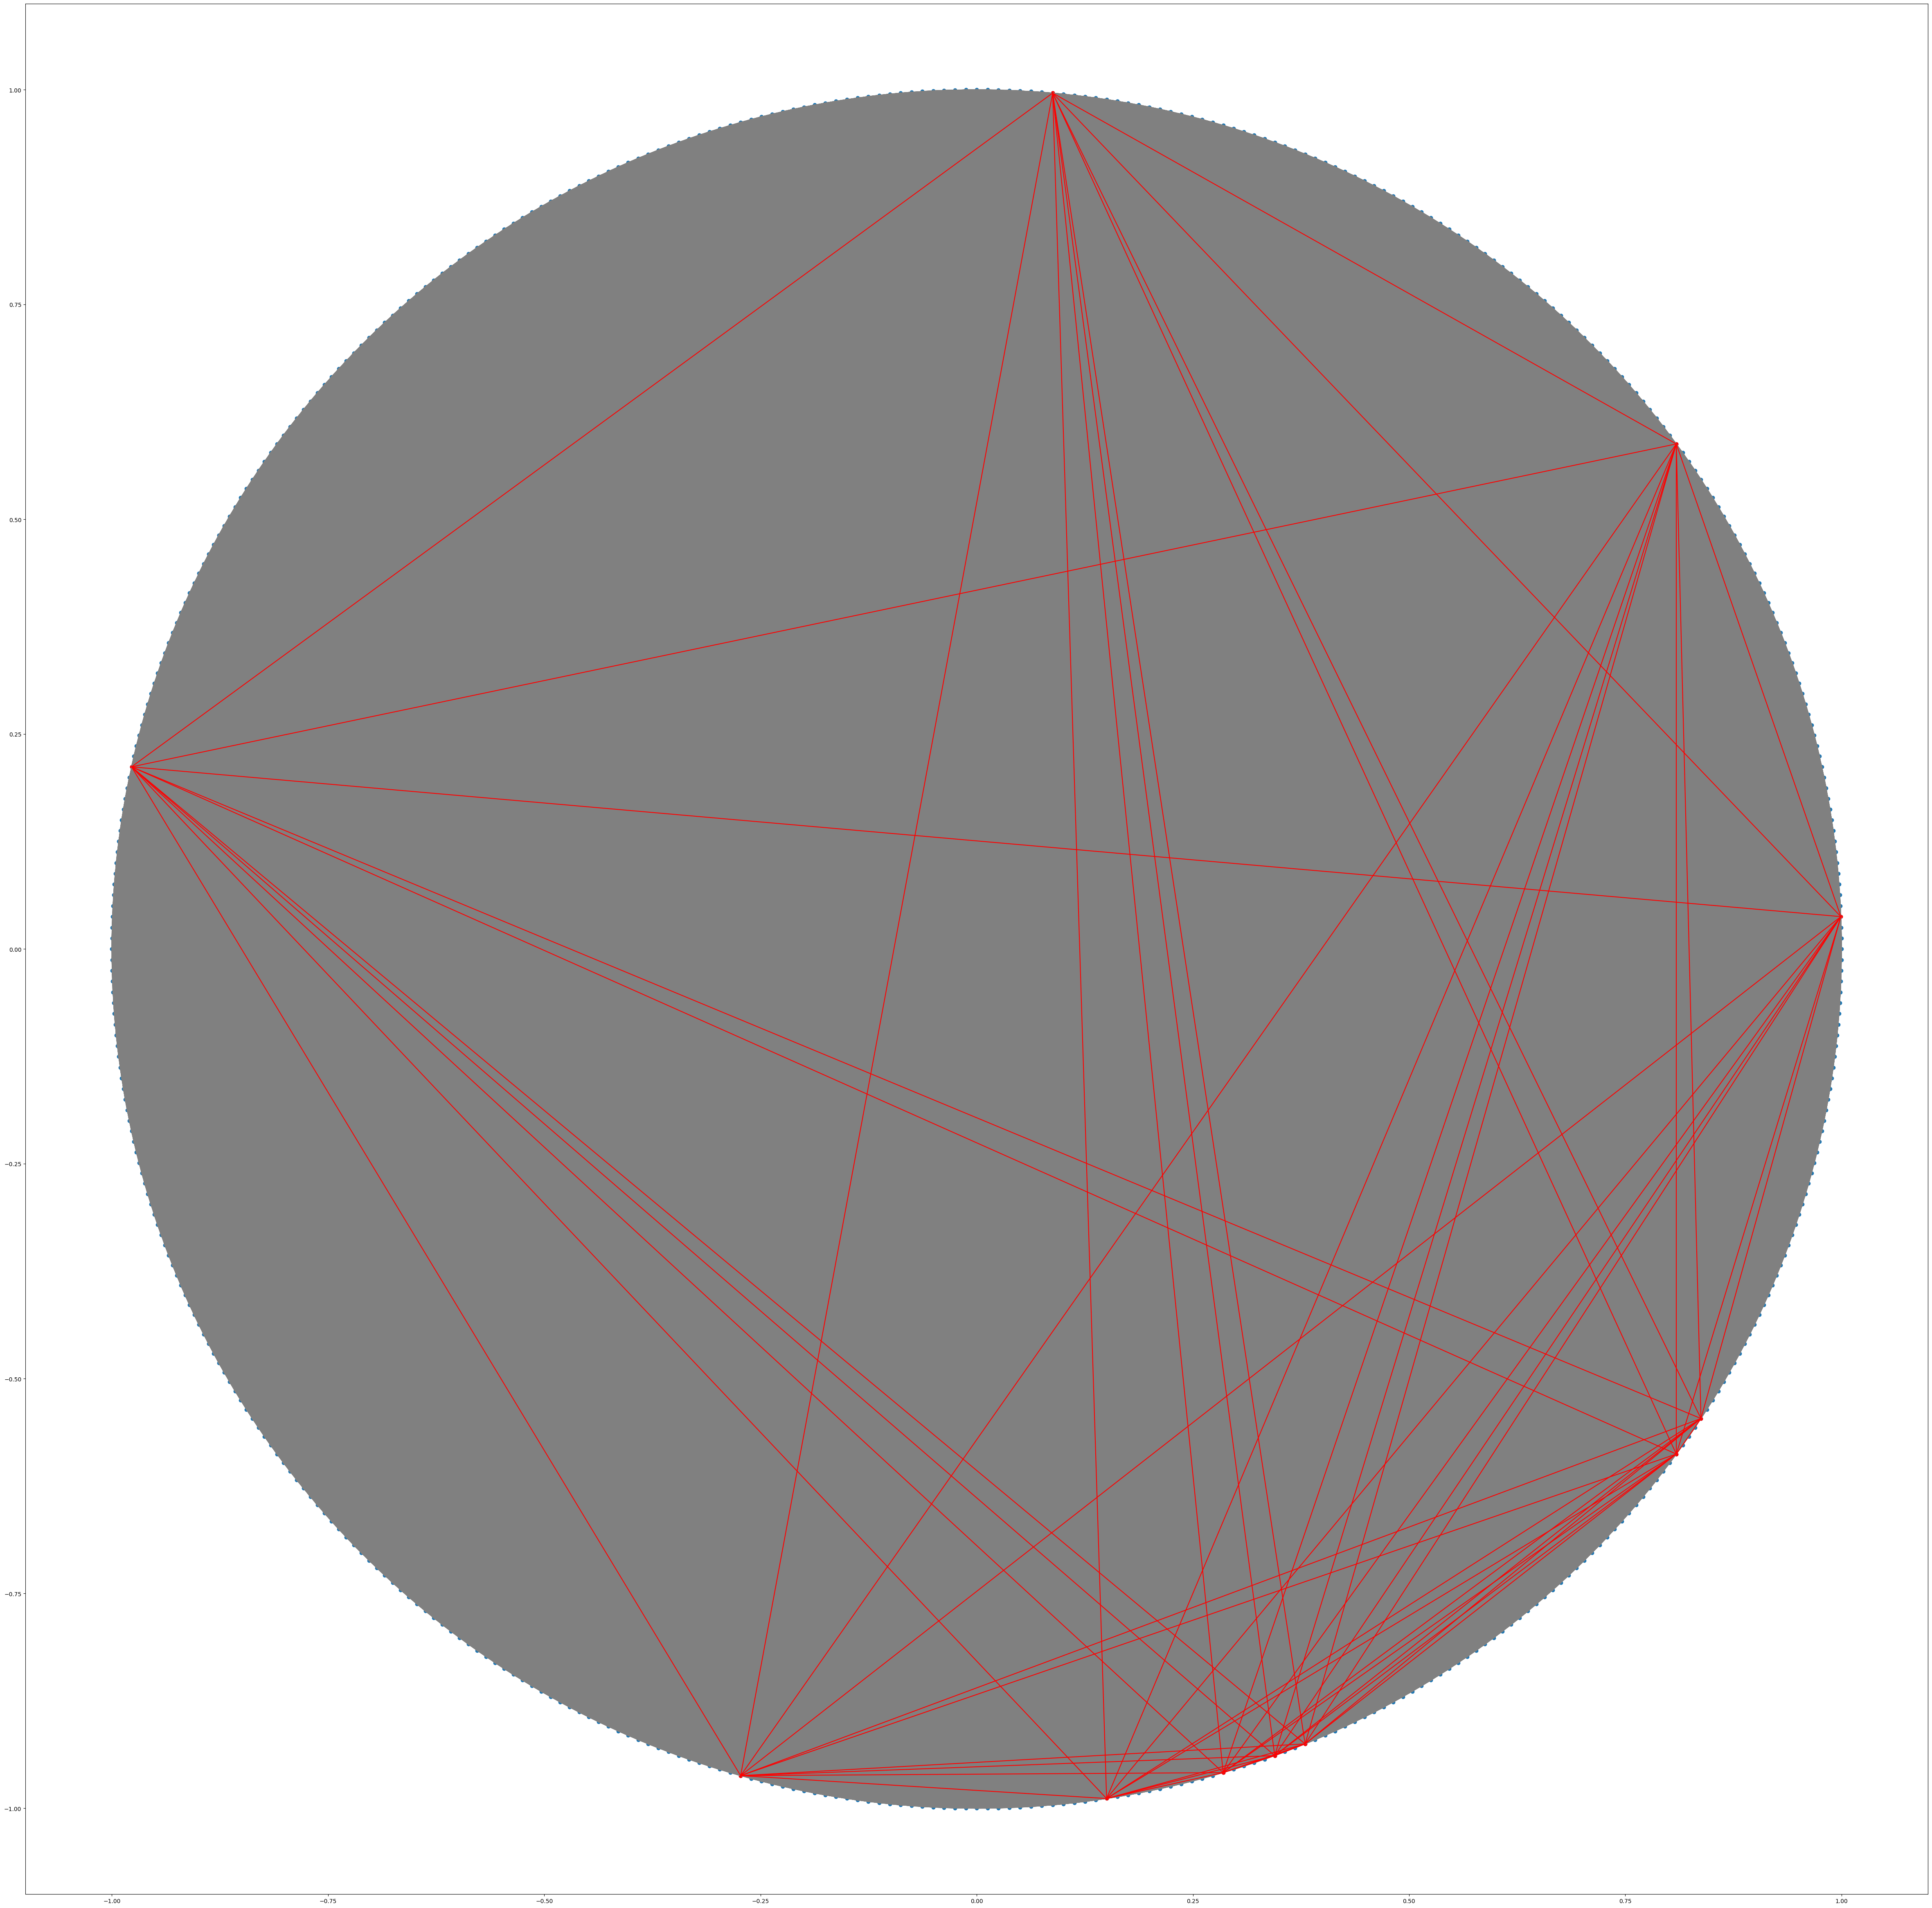

In [59]:
#draw_graph(G, bestClique)